In [1]:
# Newton method of sqrt
# this is actually Heron's method
# based on http://lomont.org/papers/2003/InvSqrt.pdf
# orignal guess within 3% of target inv_sqrt in that paper
# 0.1% after one newton step

### V1 - my own init_guess
# Here i show my init_guess for sqrt is within 6-7% of target sqrt on average (13.46% max)
# and within 0.6-0.7% (average) after one Newton step (1.05% max)

### V2 - init_guess from wikipedia
# https://en.wikipedia.org/wiki/Methods_of_computing_square_roots
# #Rough Estimation
# is worse than v1, ~17% average

### V3 - 'Approximations that depend on the floating point representation'
# seems to be slightly better than v1 on average, within 4-5% of target, but has a much worse max errore (on tiny numbers)

### V4 - Hybrid between my v1 and v3
# best yet. guess is within 1.7% average and 2.5% max off target
# 0.018% average and 0.033% max off target after one newton step


# it's still much slower than default math.sqrt()

In [2]:
import math
import random
import sys
import matplotlib.pyplot as plt
import numpy as np

In [3]:
def f(x, I):
    # function to use the newton method with
    # this function's zeroes are when x = sqrt(I)
    # the x*x product limits to floats with exponent smaller than 10^152
    return x*x - I

In [4]:
def f_p(x):
    # the derivative of the f function (doesn't include I in this case, but in general might)
    return 2*x

In [5]:
def init_sqrt_guess_1(x):
    # returns a guess for sqrt(x)
    # get the mantissa and exponent
    m, e = math.frexp(x)
    # we're looking for a new m and e such that (m*2**e)**2 ~= x
    # for the exponent it's just half
    e = e/2.0
    # for the mantissa which is in [0.5,1[ (because x is positive), the best value is obviously sqrt(m)
    # we approximate that by sqrt(x) ~= x+k
    # k = solve ((2 1^(3/2))/3 - 1^2/2 ) - ((2 0.5^(3/2))/3 - 0.5^2/2)-k/2 ==0
    # I believe this k makes the integral of sqrt(x)-(x+k) in between 0.5,1 to be zero
    # and that this is optimal as a first guess (but doesn't necessarily optimized for the first step, the second step...)
    # approximately
    k = 0.111928812542301634
    # if k = 0, guess is ~29% off
    m = m+k
    # init guess 
    g = m*(2**e)
    return g

# comments on dev of a better hex version of the init guess.
# since actually m*(2**e) == x, if m, e = math.frexp(x), and not a close number due to floating points
# maybe a hex version isn't much better

In [6]:
def init_sqrt_guess_2(x):
    # v2
    # returns a guess for sqrt(x)
    # get the mantissa and exponent
    m, e = math.frexp(x)
    # guess based on 'Rough estimation' section of wiki page linked above
    e = math.floor(e/2.0)
    # init guess 
    g = (2**e)
    return g

In [7]:
# tools to convert float from int bytes and vice-versa
# adapted from https://stackoverflow.com/questions/34402334/how-to-interpret-a-integer-as-a-float
import struct

def float_from_integer(integer):
    return struct.unpack('!f', struct.pack('!I', integer))[0]

def integer_from_float(float_num):
    return struct.unpack('!I', struct.pack('!f', float_num))[0]

# check from stackoverflow
assert float_from_integer(1066192077) == 1.100000023841858
assert integer_from_float(1.100000023841858) == 1066192077
# check from wikipedia
assert integer_from_float(1.0) == 1065353216

print(float_from_integer(1066192077))
print(integer_from_float(1.100000023841858))
print(integer_from_float(1.0))

1.10000002384
1066192077
1065353216


In [8]:
def init_sqrt_guess_3(x, magic_num=0x1fb99a06):
    # v3
    # returns a guess for sqrt(x)
    # guess based on 'Approximations that depend on the floating point representation' from wikipedia link above
    # and from https://stackoverflow.com/questions/43120045/how-does-this-float-square-root-approximation-work
    # default magic constant 0x1fbb4000 = 532365312
    # best for [0.5-1[ min-max error 0x1fb99a06 = 532257286
    g = integer_from_float(x)>>1
    g = float_from_integer(magic_num+g)
    
    return g

In [9]:
def init_sqrt_guess_4(x, magic_num=0x1fb99a06):
    # v4 hybrid between v1 and v2
    m, e = math.frexp(x)
    e = e/2.
    m = init_sqrt_guess_3(m, magic_num)
    
    g = m*2**e
    
    return g

In [10]:
def newton_sqrt(I, max_steps=1, init_guess_func=init_sqrt_guess_4, min_error=1e-10, add_noise=False, verbose=False):
    # computes the sqrt of I using the Newton method
    # default max_step=1 to mirror fast inverse sqrt paper
    # converges very fast so a very small min_error is possible
    # after 3 steps, 0% error
    
    I = float(I)
    
    # initial guess:
    x = init_guess_func(I)
    
    step=0

    abs_error = abs(x*x-I)
    rel_error = 100.0*abs_error/I
    
    if verbose:
        print("Init guess: {}".format(x))
        print("Absolute Error: {}".format(abs_error))
        print("Relative Error: {:.10f} %".format(rel_error))
    
    # takes steps until max_steps or min_error reached, whichever comes first
    while (rel_error>min_error and step<max_steps):
        
        # add noise to prevent getting stuck?
        if add_noise: x += random.random()*min_error*2
        
        # Newton step
#         x = x - f(x,I)/f_p(x) # original form
        x =(x**2+I)/(2*x)
        
        step += 1
        
        abs_error = abs(x*x-I)
        rel_error = 100.0*abs_error/I
        
        if verbose: 
            print("After step {}".format(step))
            print("Current x: {}".format(x))
            print("Absolute Error: {}".format(abs_error))
            print("Relative Error: {:.10f} %".format(rel_error))
    
    return x

In [11]:
def gen_rand_positive_32_bit_float():
    # generate a positive 32 bit float from hexadecimal
    
    # random components
    mantissa = ''.join([random.choice('01234567890abcdef') for _ in range(8)])
    # limit range 
    exponent = random.randint(a=-126, b=127)

    # combine into a string for float.fromhex()
    hex_string = '0x1.'+mantissa+'p'+str(exponent)

    # convert
    float_from_hex = float.fromhex(hex_string)
    
#     print(mantissa)
#     print(exponent)
#     print(hex_string)

    return float_from_hex

In [12]:
def gen_rand_positive_32_bit_float():
    # generates positive 32 bit floats from integers
    rand_int = random.randint(a=0, b=2139095039)
    r = float_from_integer(rand_int)
    if r!=r:
        print("NAN", rand_int)
    return r

In [13]:
# test some known values
num_to_test = 0.64
print("One step newton computation with default init_guess:", newton_sqrt(num_to_test))
print("V1 init guess", init_sqrt_guess_1(num_to_test))
print("V2 init guess", init_sqrt_guess_2(num_to_test))
print("V3 init guess", init_sqrt_guess_3(num_to_test))
print("V4 init guess", init_sqrt_guess_4(num_to_test))

('One step newton computation with default init_guess:', 0.8000156825781851)
('V1 init guess', 0.7519288125423016)
('V2 init guess', 1.0)
('V3 init guess', 0.7950064539909363)
('V4 init guess', 0.7950064539909363)


In [14]:
# see the computation
print(newton_sqrt(num_to_test, verbose=True))

Init guess: 0.795006453991
Absolute Error: 0.00796473811276
Relative Error: 1.2444903301 %
After step 1
Current x: 0.800015682578
Absolute Error: 2.50923710394e-05
Relative Error: 0.0039206830 %
0.800015682578


In [15]:
# test some random values
num_to_test = gen_rand_positive_32_bit_float()
print("Number to test: {}".format(num_to_test))

# my computation
print("My computation")
my_result = newton_sqrt(num_to_test, max_steps=6, min_error=1e-200, add_noise=False, verbose=True)

# python's computation
python_result = math.sqrt(num_to_test)

# compare
print("")
print("my results: {0:.100f}".format(my_result))
print("python's  : {0:.100f}".format(python_result))
my_error = abs(my_result*my_result-num_to_test)
print("Newton Absolute Error: {}".format(my_error))
print("Newton Relative Error: {:.5f}%".format(100.0*my_error/num_to_test))

py_error = abs(python_result*python_result-num_to_test)
print("Python Absolute Error: {}".format(py_error))
print("Python Relative Error: {:.5f}%".format(100.0*py_error/num_to_test))

Number to test: 1.20825238023e+33
My computation
Init guess: 3.38817815224e+16
Absolute Error: 6.02772611017e+31
Relative Error: 4.9887972155 %
After step 1
Current x: 3.47713047174e+16
Absolute Error: 7.91251514377e+29
Relative Error: 0.0654872713 %
After step 2
Current x: 3.47599267791e+16
Absolute Error: 1.29457478157e+26
Relative Error: 0.0000107144 %
After step 3
Current x: 3.4759924917e+16
Absolute Error: 3.45876451382e+18
Relative Error: 0.0000000000 %
After step 4
Current x: 3.4759924917e+16
Absolute Error: 1.44115188076e+17
Relative Error: 0.0000000000 %
After step 5
Current x: 3.4759924917e+16
Absolute Error: 1.44115188076e+17
Relative Error: 0.0000000000 %
After step 6
Current x: 3.4759924917e+16
Absolute Error: 1.44115188076e+17
Relative Error: 0.0000000000 %

my results: 34759924916968072.0000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000
python's  : 34759924916968072.00000000000000000000000000000000000000000000000000000000

In [16]:
### Timing Tests

In [17]:
%%timeit -n 2000000 -r 5
num_to_test = gen_rand_positive_32_bit_float()

2000000 loops, best of 5: 2.49 µs per loop


In [18]:
%%timeit -n 2000000 -r 5
num_to_test = gen_rand_positive_32_bit_float()
math.sqrt(num_to_test)

2000000 loops, best of 5: 2.49 µs per loop


In [19]:
# math.sqrt() takes about 0.57 µs

In [20]:
%%timeit -n 2000000 -r 5
num_to_test = gen_rand_positive_32_bit_float()
init_sqrt_guess_1(num_to_test)

2000000 loops, best of 5: 3.52 µs per loop


In [21]:
%%timeit -n 2000000 -r 5
num_to_test = gen_rand_positive_32_bit_float()
init_sqrt_guess_3(num_to_test)

2000000 loops, best of 5: 4.12 µs per loop


In [22]:
%%timeit -n 2000000 -r 5
num_to_test = gen_rand_positive_32_bit_float()
init_sqrt_guess_4(num_to_test)

2000000 loops, best of 5: 5.07 µs per loop


In [23]:
%%timeit -n 2000000 -r 5
num_to_test = gen_rand_positive_32_bit_float()
newton_sqrt(num_to_test, max_steps=0)

2000000 loops, best of 5: 6.27 µs per loop


In [24]:
%%timeit -n 2000000 -r 5
num_to_test = gen_rand_positive_32_bit_float()
newton_sqrt(num_to_test, max_steps=1)

2000000 loops, best of 5: 7.4 µs per loop


In [25]:
%%timeit -n 2000000 -r 5
num_to_test = gen_rand_positive_32_bit_float()
newton_sqrt(num_to_test, max_steps=2)

2000000 loops, best of 5: 8.64 µs per loop


In [26]:
%%timeit -n 2000000 -r 5
num_to_test = gen_rand_positive_32_bit_float()
newton_sqrt(num_to_test, max_steps=3)

2000000 loops, best of 5: 9.41 µs per loop


In [27]:
%%timeit -n 2000000 -r 5
num_to_test = gen_rand_positive_32_bit_float()
newton_sqrt(num_to_test, max_steps=4)

2000000 loops, best of 5: 9.55 µs per loop


In [28]:
%%timeit -n 2000000 -r 5
num_to_test = gen_rand_positive_32_bit_float()
newton_sqrt(num_to_test, max_steps=5)

2000000 loops, best of 5: 9.27 µs per loop


In [29]:
%%timeit -n 2000000 -r 5
num_to_test = gen_rand_positive_32_bit_float()
newton_sqrt(num_to_test, max_steps=6)

2000000 loops, best of 5: 9.23 µs per loop


In [30]:
# seems about 20 times slower with maxstep=1

In [31]:
# test over a bunch of floats, to evaluate the impact of the number of steps

num_samples = 2000000

for max_steps in range(10):
    print("Testing with max_steps={}".format(max_steps))
    
    max_abs_error = -1
    max_abs_err_num = -1
    max_abs_err_res = -1
    
    max_rel_error = -1
    max_rel_err_num = -1
    max_rel_err_res =-1
    
    max_sqrt_abs_error = -1
    max_sqrt_abs_err_num = -1
    max_sqrt_abs_err_res = -1
    
    max_sqrt_rel_error = -1
    max_sqrt_abs_err_num = -1
    max_sqrt_abs_err_res  -1
    
    average_abs_err = 0
    average_rel_err = 0
    average_abs_sqrt_err = 0
    average_rel_sqrt_err = 0
    
    for _ in xrange(num_samples):
        # generate a new random value
        num_to_test = gen_rand_positive_32_bit_float()

        # compute my sqrt
        my_result = newton_sqrt(num_to_test, max_steps=max_steps, min_error=1e-100, add_noise=False, verbose=False)
        
        my_abs_error = abs(my_result*my_result-num_to_test)
        my_rel_error = 100.0*my_abs_error/num_to_test
        
        sqrt_abs_error = abs(my_result-math.sqrt(num_to_test))
        sqrt_rel_error = 100.0*sqrt_abs_error/math.sqrt(num_to_test)
        
        average_abs_err += my_abs_error
        average_rel_err += my_rel_error
        average_abs_sqrt_err += sqrt_abs_error
        average_rel_sqrt_err += sqrt_rel_error
        
        if (max_abs_error == -1) or (my_abs_error>max_abs_error):
            max_abs_error = my_abs_error
            max_abs_err_num = num_to_test
            max_abs_err_res = my_result*my_result
            
        if (max_rel_error == -1) or (my_rel_error>max_rel_error):
            max_rel_error = my_rel_error
            max_rel_err_num = num_to_test
            max_rel_err_res = my_result*my_result

        if (max_sqrt_abs_error == -1) or (sqrt_abs_error>max_sqrt_abs_error):
            max_sqrt_abs_error = sqrt_abs_error
            max_sqrt_abs_err_num = math.sqrt(num_to_test)
            max_sqrt_abs_err_res = my_result
            
        if (max_sqrt_rel_error == -1) or (sqrt_rel_error>max_sqrt_rel_error):
            max_sqrt_rel_error = sqrt_rel_error
            max_sqrt_rel_err_num = math.sqrt(num_to_test)
            max_sqrt_rel_err_res = my_result

    average_abs_err /= num_samples
    average_rel_err /= num_samples
    average_abs_sqrt_err /= num_samples
    average_rel_sqrt_err /= num_samples
            
    print("Max absolute error: {} (result: {}  target: {})".format(max_abs_error, max_abs_err_res, max_abs_err_num))
    print("Max relative error: {}% (result: {}  target: {})".format(max_rel_error, max_rel_err_res, max_rel_err_num))
    print("Max sqrt absolute error: {} (result: {}  target: {})".format(max_sqrt_abs_error, max_sqrt_abs_err_res, max_sqrt_abs_err_num))
    print("Max sqrt relative error: {}% (result: {}  target: {})".format(max_sqrt_rel_error, max_sqrt_rel_err_res, max_sqrt_rel_err_num))
    print("Average absolute error: {}".format(average_abs_err))
    print("Average relative error: {}%".format(average_rel_err))
    print("Average sqrt absolute error: {}".format(average_abs_sqrt_err))
    print("Average sqrt relative error: {}%".format(average_rel_sqrt_err))
    print('')
    

Testing with max_steps=0
Max absolute error: 1.67971281956e+37 (result: 3.2348418404e+38  target: 3.40281312236e+38)
Max relative error: 5.12686596127% (result: 4.01027263738e-06  target: 3.81469817512e-06)
Max sqrt absolute error: 4.61049956065e+17 (result: 1.79851350075e+19  target: 1.84461849636e+19)
Max sqrt relative error: 2.53139671246% (result: 1.2812817034e-06  target: 1.3145583913e-06)
Average absolute error: 7.28704747025e+34
Average relative error: 3.42485090936%
Average sqrt absolute error: 3.79195998324e+15
Average sqrt relative error: 1.72656186061%

Testing with max_steps=1
Max absolute error: 2.18051893096e+35 (result: 3.40295911278e+38  target: 3.40077859385e+38)
Max relative error: 0.0657547385768% (result: 4.59700222808e+24  target: 4.59398146757e+24)
Max sqrt absolute error: 5.94825316462e+15 (result: 1.82171904353e+19  target: 1.82112421821e+19)
Max sqrt relative error: 0.0328719664575% (result: 2.14406208587e+12  target: 2.14335752211e+12)
Average absolute error: 

In [32]:
#### Evaluation of the init_guess

for i,init_guess_func in enumerate([init_sqrt_guess_1, init_sqrt_guess_2, init_sqrt_guess_3, init_sqrt_guess_4]):
    
    print("Evaluating init guess function {}".format(i+1))
    
    num_samples = 2000000


    max_abs_error = -1
    max_abs_err_num = -1
    max_abs_err_res = -1

    max_rel_error = -1
    max_rel_err_num = -1
    max_rel_err_res =-1

    max_sqrt_abs_error = -1
    max_sqrt_abs_err_num = -1
    max_sqrt_abs_err_res = -1

    max_sqrt_rel_error = -1
    max_sqrt_abs_err_num = -1
    max_sqrt_abs_err_res  -1

    average_abs_err = 0
    average_rel_err = 0
    average_abs_sqrt_err = 0
    average_rel_sqrt_err = 0

    for _ in xrange(num_samples):
        # generate a new random value
        num_to_test = gen_rand_positive_32_bit_float()

        # compute my guess
        my_result = init_guess_func(num_to_test)

        my_abs_error = abs(my_result*my_result-num_to_test)
        my_rel_error = 100.0*my_abs_error/num_to_test

        sqrt_abs_error = abs(my_result-math.sqrt(num_to_test))
        sqrt_rel_error = 100.0*sqrt_abs_error/math.sqrt(num_to_test)

        average_abs_err += my_abs_error
        average_rel_err += my_rel_error
        average_abs_sqrt_err += sqrt_abs_error
        average_rel_sqrt_err += sqrt_rel_error

        if (max_abs_error == -1) or (my_abs_error>max_abs_error):
            max_abs_error = my_abs_error
            max_abs_err_num = num_to_test
            max_abs_err_res = my_result*my_result

        if (max_rel_error == -1) or (my_rel_error>max_rel_error):
            max_rel_error = my_rel_error
            max_rel_err_num = num_to_test
            max_rel_err_res = my_result*my_result

        if (max_sqrt_abs_error == -1) or (sqrt_abs_error>max_sqrt_abs_error):
            max_sqrt_abs_error = sqrt_abs_error
            max_sqrt_abs_err_num = math.sqrt(num_to_test)
            max_sqrt_abs_err_res = my_result

        if (max_sqrt_rel_error == -1) or (sqrt_rel_error>max_sqrt_rel_error):
            max_sqrt_rel_error = sqrt_rel_error
            max_sqrt_rel_err_num = math.sqrt(num_to_test)
            max_sqrt_rel_err_res = my_result

    average_abs_err /= num_samples
    average_rel_err /= num_samples
    average_abs_sqrt_err /= num_samples
    average_rel_sqrt_err /= num_samples

    print("Max absolute error: {} (result: {}  target: {})".format(max_abs_error, max_abs_err_res, max_abs_err_num))
    print("Max relative error: {}% (result: {}  target: {})".format(max_rel_error, max_rel_err_res, max_rel_err_num))
    print("Max sqrt absolute error: {} (result: {}  target: {})".format(max_sqrt_abs_error, max_sqrt_abs_err_res, max_sqrt_abs_err_num))
    print("Max sqrt relative error: {}% (result: {}  target: {})".format(max_sqrt_rel_error, max_sqrt_rel_err_res, max_sqrt_rel_err_num))
    print("Average absolute error: {}".format(average_abs_err))
    print("Average relative error: {}%".format(average_rel_err))
    print("Average sqrt absolute error: {}".format(average_abs_sqrt_err))
    print("Average sqrt relative error: {}%".format(average_rel_sqrt_err))
    print('')


Evaluating init guess function 1
Max absolute error: 8.04336602748e+37 (result: 4.20712579186e+38  target: 3.40278918911e+38)
Max relative error: 25.1085407495% (result: 3.60589904657e-35  target: 4.81483347055e-35)
Max sqrt absolute error: 2.06462870119e+18 (result: 2.05112793162e+19  target: 1.8446650615e+19)
Max sqrt relative error: 13.4601483417% (result: 6.00491385998e-18  target: 6.93890010776e-18)
Average absolute error: 2.43005874017e+35
Average relative error: 12.2277744936%
Average sqrt absolute error: 1.29689209881e+16
Average sqrt relative error: 6.16351777948%

Evaluating init guess function 2
Max absolute error: 1.70136559071e+38 (result: 3.40282366921e+38  target: 1.7014580785e+38)
Max relative error: 99.9999761581% (result: 7.92281625143e+28  target: 3.96140859795e+28)
Max sqrt absolute error: 5.40274898594e+18 (result: 1.84467440737e+19  target: 1.30439950878e+19)
Max sqrt relative error: 41.4213478079% (result: 2.81474976711e+14  target: 1.9903287663e+14)
Average abso

In [33]:
### evaluate various magic numbers

In [34]:
def evaluate_magic_num_v3(magic_num, num_samples=100000, verbose=False):
    # evaluate v3 in between [0.5,1[

    max_abs_error = -1
    max_abs_err_num = -1
    max_abs_err_res = -1

    max_rel_error = -1
    max_rel_err_num = -1
    max_rel_err_res =-1

    max_sqrt_abs_error = -1
    max_sqrt_abs_err_num = -1
    max_sqrt_abs_err_res = -1

    max_sqrt_rel_error = -1
    max_sqrt_abs_err_num = -1
    max_sqrt_abs_err_res  -1

    average_abs_err = 0
    average_rel_err = 0
    average_abs_sqrt_err = 0
    average_rel_sqrt_err = 0

    for _ in range(num_samples):

        num_to_test = 0.5+random.random()/2.0
        my_result = init_sqrt_guess_3(num_to_test, magic_num=magic_num)

        my_abs_error = abs(my_result*my_result-num_to_test)
        my_rel_error = 100.0*my_abs_error/num_to_test

        sqrt_abs_error = abs(my_result-math.sqrt(num_to_test))
        sqrt_rel_error = 100.0*sqrt_abs_error/math.sqrt(num_to_test)

        average_abs_err += my_abs_error
        average_rel_err += my_rel_error
        average_abs_sqrt_err += sqrt_abs_error
        average_rel_sqrt_err += sqrt_rel_error

        if (max_abs_error == -1) or (my_abs_error>max_abs_error):
            max_abs_error = my_abs_error
            max_abs_err_num = num_to_test
            max_abs_err_res = my_result*my_result

        if (max_rel_error == -1) or (my_rel_error>max_rel_error):
            max_rel_error = my_rel_error
            max_rel_err_num = num_to_test
            max_rel_err_res = my_result*my_result

        if (max_sqrt_abs_error == -1) or (sqrt_abs_error>max_sqrt_abs_error):
            max_sqrt_abs_error = sqrt_abs_error
            max_sqrt_abs_err_num = math.sqrt(num_to_test)
            max_sqrt_abs_err_res = my_result

        if (max_sqrt_rel_error == -1) or (sqrt_rel_error>max_sqrt_rel_error):
            max_sqrt_rel_error = sqrt_rel_error
            max_sqrt_rel_err_num = math.sqrt(num_to_test)
            max_sqrt_rel_err_res = my_result

    average_abs_err /= num_samples
    average_rel_err /= num_samples
    average_abs_sqrt_err /= num_samples
    average_rel_sqrt_err /= num_samples


    if verbose:
        print("Evaluating constant {} = {} in between [0.5,1[".format(hex(magic_num), magic_num))
        print("Max absolute error: {} (result: {}  target: {})".format(max_abs_error, max_abs_err_res, max_abs_err_num))
        print("Max relative error: {}% (result: {}  target: {})".format(max_rel_error, max_rel_err_res, max_rel_err_num))
        print("Max sqrt absolute error: {} (result: {}  target: {})".format(max_sqrt_abs_error, max_sqrt_abs_err_res, max_sqrt_abs_err_num))
        print("Max sqrt relative error: {}% (result: {}  target: {})".format(max_sqrt_rel_error, max_sqrt_rel_err_res, max_sqrt_rel_err_num))
        print("Average absolute error: {}".format(average_abs_err))
        print("Average relative error: {}%".format(average_rel_err))
        print("Average sqrt absolute error: {}".format(average_abs_sqrt_err))
        print("Average sqrt relative error: {}%".format(average_rel_sqrt_err))
        
    return(max_sqrt_abs_error, max_sqrt_rel_error, average_abs_sqrt_err, average_rel_sqrt_err)


In [35]:
### Evaluate the magic number given by stackoverflow
evaluate_magic_num_v3(0x1fbb4000, num_samples=2000000, verbose=True)

print 

### Evaluate the one I found, which minimizes the max error
evaluate_magic_num_v3(0x1fb99a06, num_samples=2000000, verbose=True)

Evaluating constant 0x1fbb4000 = 532365312 in between [0.5,1[
Max absolute error: 0.0367651629197 (result: 0.963233965449  target: 0.999999128369)
Max relative error: 7.00243384205% (result: 0.535012419568  target: 0.500000233974)
Max sqrt absolute error: 0.024338485078 (result: 0.731445431709  target: 0.707106946631)
Max sqrt relative error: 3.44198076316% (result: 0.731445431709  target: 0.707106946631)
Average absolute error: 0.0213370874035
Average relative error: 2.81060187099%
Average sqrt absolute error: 0.0122025043626
Average sqrt relative error: 1.40793031125%

Evaluating constant 0x1fb99a06 = 532257286 in between [0.5,1[
Max absolute error: 0.0493624583495 (result: 0.950637250582  target: 0.999999708932)
Max relative error: 5.12683069532% (result: 0.525634800837  target: 0.50000061579)
Max sqrt absolute error: 0.0249935832106 (result: 0.974989235401  target: 0.999982818612)
Max sqrt relative error: 2.53139821952% (result: 0.950000524521  target: 0.974673389345)
Average absol

(0.024993583210597525,
 2.5313982195202533,
 0.015392460912431155,
 1.728110368675623)

In [36]:
# explore the vicinity of the default magic number for [0.5-1[

best_max_sqrt_abs_error = sys.float_info.max
best_max_sqrt_abs_error_num = -1

best_max_sqrt_rel_error = sys.float_info.max
best_max_sqrt_rel_error_num = -1

best_average_abs_sqrt_err = sys.float_info.max
best_average_abs_sqrt_err_num = -1

best_average_rel_sqrt_err = sys.float_info.max
best_average_rel_sqrt_err_num = -1

delta = 0 
starting_magic_num = 0x1fb99a06


delta_list = []
max_sqrt_rel_error_list = []
average_rel_sqrt_err_list = []

for i in range(1,100):
#     print("Evaluating delta {}, hex {}".format(delta, hex(delta+starting_magic_num)))
    
    # eval
    max_sqrt_abs_error, max_sqrt_rel_error, average_abs_sqrt_err, average_rel_sqrt_err = evaluate_magic_num_v3(
        magic_num=starting_magic_num+delta, num_samples=2000000, verbose=False)
    
    # save bests
    if max_sqrt_abs_error < best_max_sqrt_abs_error:
        best_max_sqrt_abs_error = max_sqrt_abs_error
        best_max_sqrt_abs_error_num = starting_magic_num+delta
        
    if max_sqrt_rel_error < best_max_sqrt_rel_error:
        best_max_sqrt_rel_error = max_sqrt_rel_error
        best_max_sqrt_rel_error_num = starting_magic_num+delta
        
    if average_abs_sqrt_err < best_average_abs_sqrt_err:
        best_average_abs_sqrt_err = average_abs_sqrt_err
        best_average_abs_sqrt_err_num = starting_magic_num+delta
        
    if average_rel_sqrt_err < best_average_rel_sqrt_err:
        best_average_rel_sqrt_err = average_rel_sqrt_err
        best_average_rel_sqrt_err_num = starting_magic_num+delta
       
    
    # append to lists
    delta_list.append(delta)
    max_sqrt_rel_error_list.append(max_sqrt_rel_error)
    average_rel_sqrt_err_list.append(average_rel_sqrt_err)
    
    # next delta
    delta = -1*delta+i%2*int(np.log2(i+1)/np.log2(2))
    
print("best_max_sqrt_abs_error", best_max_sqrt_abs_error, best_max_sqrt_abs_error_num)
print("best_max_sqrt_rel_error", best_max_sqrt_rel_error, best_max_sqrt_rel_error_num)
print("best_average_abs_sqrt_err", best_average_abs_sqrt_err, best_average_abs_sqrt_err_num)
print("best_average_rel_sqrt_err", best_average_rel_sqrt_err, best_average_rel_sqrt_err_num)

('best_max_sqrt_abs_error', 0.02497945723893913, 532257523)
('best_max_sqrt_rel_error', 2.531392082727419, 532257287)
('best_average_abs_sqrt_err', 0.015366470516089947, 532257475)
('best_average_rel_sqrt_err', 1.7255378588506212, 532257475)


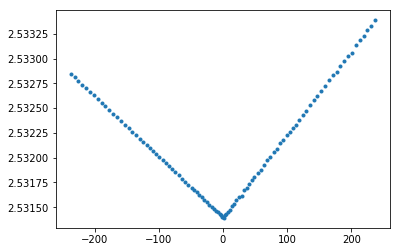

In [37]:
plt.plot(delta_list, max_sqrt_rel_error_list, '.')
plt.show()

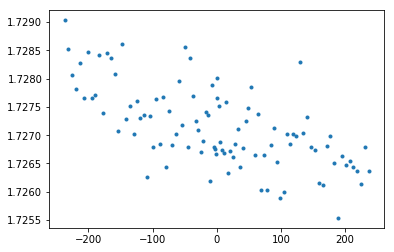

In [38]:
plt.plot(delta_list, average_rel_sqrt_err_list, '.')
plt.show()

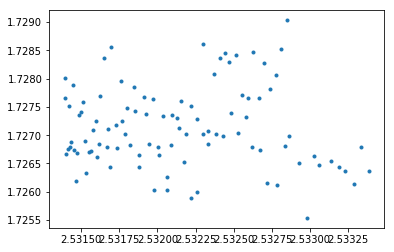

In [39]:
plt.plot(max_sqrt_rel_error_list, average_rel_sqrt_err_list, '.')
plt.show()